In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy 

import textwrap

import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../../..')
# print(root_path)
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data

# Import linear synthetic data creation
from causaltune.datasets import generate_linear_synthetic_data

In [2]:
# set a few params
metrics = [
    #"frobenius_norm",
    #"prob_erupt",
    "policy_risk",
    #"codec",
    #"energy_distance", 
    #"psw_energy_distance"
    ]
    
n_samples = 1000
test_size = 0.33 # equal train,val,test
#time_budget = 21600
components_time_budget = 600

estimator_list = [
             #"Dummy",
             "SparseLinearDML",
             "ForestDRLearner",
             "TransformedOutcome",
             "CausalForestDML",
             ".LinearDML",
             "DomainAdaptationLearner",
             #"SLearner",
             "XLearner",
             #"TLearner",
             #"Ortho"        
    ] 

n_runs = 1
out_dir = ""
filename_out = "policy_risk_updated_600" 

# 1. Dataset Generation

In [3]:
# Create empty dictionary
data_sets = {}

### 1.1 Non-linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [4]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
cd_non_linear.preprocess_dataset()
data_sets['rct_non-linear'] = cd_non_linear

In [5]:
cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
cd_non_linear.preprocess_dataset()
data_sets['known_confounders_non-linear'] = cd_non_linear

In [6]:
#cd_non_linear = generate_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_non_linear.preprocess_dataset()
#data_sets['IV_non-linear'] = cd_non_linear
#cd_linear.data.head(5)

### 1.2 Linear Data
Unkown Confounders (RCT), Known Confoudners (Observational), IV

In [7]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=False, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['Unknown_Confounders_linear'] = cd_linear

In [8]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, noisy_outcomes=True)
#cd_linear.preprocess_dataset()
#data_sets['Known_Confounders_linear'] = cd_linear

In [9]:
#cd_linear = generate_linear_synthetic_data(n_samples=n_samples, confounding=True, add_instrument=True)
#cd_linear.preprocess_dataset()
#data_sets['IV_linear'] = cd_linear
#cd_linear.data.head(5)

# 2. Model Fitting

In [10]:
import time

run_times = {}

start_time = time.time()

for dataset_name, cd in data_sets.items():
    print("----------------- DATA SET: ",dataset_name)
    
    for i_run in range(1,n_runs+1):
        
        cd_i = copy.deepcopy(cd)
        train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
        test_df = test_df.reset_index(drop=True)
        cd_i.data = train_df
        
        for metric in metrics:

            print("___________________________________________________________________________")
            print("EVALUATING: ", metric)
    
            start_time_metric = time.time()
            
            ct = CausalTune(
                metric=metric,
                metrics_to_report = [metric],
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
            )

            ct.fit(
                data=cd_i,
                treatment="treatment",
                outcome="outcome",
            )

            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric in ["energy_distance", "psw_energy_distance", "codec"] else True,
                )

            end_time_metric = time.time()
            compute_time_metric = end_time_metric - start_time_metric
    
            print(f"COMPUTE TIME METRIC: {compute_time_metric} seconds")

            run_times[metric]=compute_time_metric

            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
                "run_time": compute_time_metric
            }

            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}_{dataset_name}.pkl", "wb") as f:
                pickle.dump(results, f)
            
            print("DONE WITH METRIC...")
    
            print("___________________________________________________________________________")


end_time = time.time()
total_time = end_time - start_time
print("TOTAL RUNTIME: ",total_time)



[flaml.tune.tune: 07-24 23:21:47] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-24 23:21:47] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


----------------- DATA SET:  rct_non-linear
___________________________________________________________________________
EVALUATING:  policy_risk
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n

[flaml.tune.tune: 07-25 00:01:47] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-25 00:31:47] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-25 00:51:48] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-25 01:11:48] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10801.64660358429 seconds
DONE WITH METRIC...
___________________________________________________________________________
----------------- DATA SET:  known_confounders_non-linear
___________________________________________________________________________
EVALUATING:  policy_risk


[flaml.tune.tune: 07-25 02:21:49] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 07-25 02:21:49] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': True, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 0.0001, 'max_iter': 10000, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.Ca

[flaml.tune.tune: 07-25 03:01:49] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 07-25 03:31:49] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 07-25 03:51:50] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.LinearDML', 'fit_cate_intercept': 1, 'mc_agg': 'mean'}}
[flaml.tune.tune: 07-25 04:11:50] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}
[flaml.tu

COMPUTE TIME METRIC: 10801.789653539658 seconds
DONE WITH METRIC...
___________________________________________________________________________
TOTAL RUNTIME:  21603.447563886642


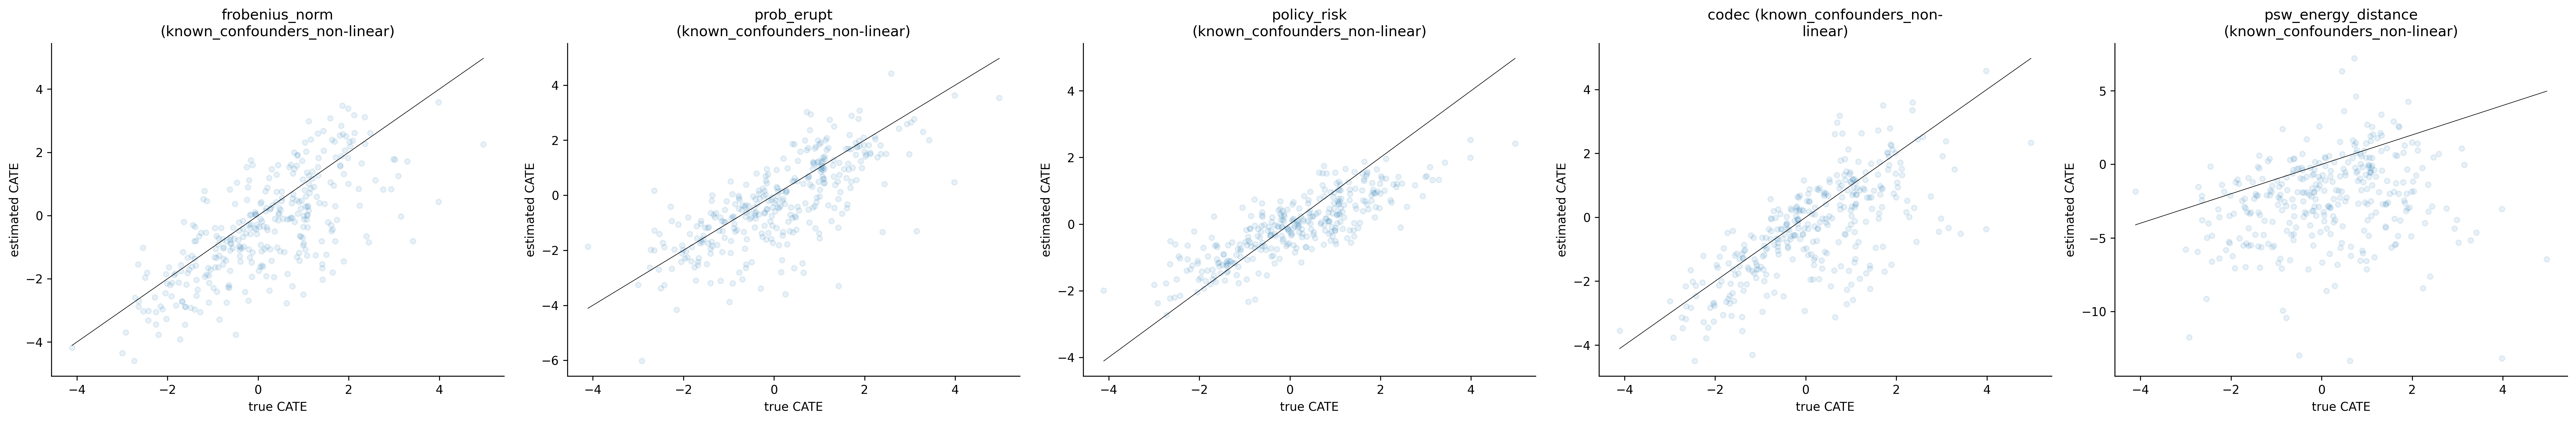

In [12]:
%matplotlib inline

# Define list of experiments to iterate over
trials = list(data_sets.keys())

# Define the number of rows and columns for the subplots
n_rows = len(trials)
n_cols = len(metrics)

# Create subplots
f, axs = plt.subplots(n_rows, n_cols, figsize=(30, 5 * n_rows), dpi=300)

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
if n_rows == 1 and n_cols == 1:
    axs = [[axs]]
elif n_rows == 1:
    axs = [axs]
elif n_cols == 1:
    axs = [[ax] for ax in axs]

# Plot true against estimated for best estimator
for row, trial in enumerate(trials):
    for col, metric in enumerate(metrics):
        ax = axs[row][col]
        with open(f"{out_dir}{filename_out}_{metric}_run_1_{trial}.pkl", "rb") as f:
            results = pickle.load(f)
        CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
        CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]

        ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)
        ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)
        ax.set_xlabel("true CATE")
        ax.set_ylabel("estimated CATE")
        
        # Wrap the title text to a specific width
        title_text = f"{results['optimised_metric']} ({trial})"
        wrapped_title = "\n".join(textwrap.wrap(title_text, width=30))  # Adjust the width as needed
        ax.set_title(wrapped_title)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(f"paper_{filename_out}_scores.pdf",format="pdf")
plt.show()